# Satellite Data Spike

In [14]:
import rasterio
import numpy
from rasterio.plot import show
import matplotlib.pyplot as plt

image_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_SR_8b.tif'
metadata_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_8b_metadata.xml'

# Load red and NIR bands - note all PlanetScope 8-band images have band order:
# Band 1 = Coastal Blue
# Band 2 = Blue
# Band 3 = Green I
# Band 4 = Green
# Band 5 = Yellow
# Band 6 = Red
# Band 7 = Red Edge
# Band 8 = Near Infrared
with rasterio.open(image_file) as src:
    band_red = src.read(3)
    band_nir = src.read(4)

In [ ]:
def pct_clip(array,pct=[2,98]):
    array_min, array_max = numpy.nanpercentile(array,pct[0]), numpy.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

# extracts bands 2 (blue), 4 (green), and 6 (red),
with rasterio.open(image_file) as src:
    with rasterio.open(
            'RGB_Temp.tif', 'w+',
            driver='GTiff',
            dtype= rasterio.float32,
            count=3,
            crs = src.crs,
            width=src.width,
            height=src.height,
            transform=src.transform,
        ) as dst:
        V = pct_clip(src.read(6))
        dst.write(V,1)
        V = pct_clip(src.read(4))
        dst.write(V,2)
        V = pct_clip(src.read(2))
        dst.write(V,3)

fig,ax=plt.subplots()
with rasterio.open("RGB_Temp.tif") as src2:
    show(src2.read(),transform=src2.transform,ax=ax)

In [2]:
from xml.dom import minidom

xmldoc = minidom.parse(metadata_file)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")


# XML parser refers to bands by numbers 1-8
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    i = int(bn)
    value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
    coeffs[i] = float(value)

In [3]:
# Multiply by corresponding coefficients
band_red = band_red * coeffs[6]
band_nir = band_nir * coeffs[8]

In [11]:
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [13]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

fig,ax=plt.subplots()
with rasterio.open('ndvi.tif') as out:
    show(out.read(),transform=out.transform,ax=ax)

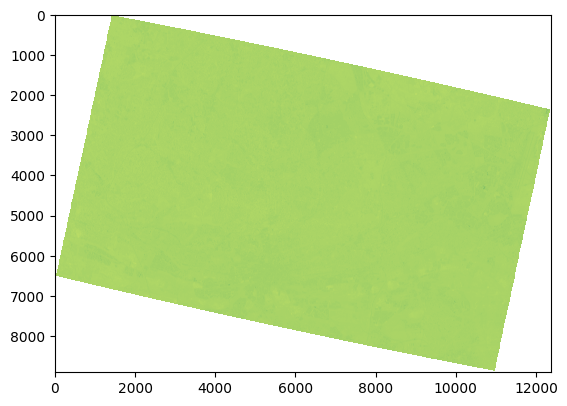

In [9]:
plt.imshow(ndvi, cmap=plt.cm.summer)

In [ ]:


fig,ax=plt.subplots()
with rasterio.open('ndvi_cmap.png') as src2:
    show(src2.read(),transform=src2.transform,ax=ax)